# HIP 65426 - ERS 1386

This program will perform coronagraphic observations of the exoplanet host star HIP 65426 at two separate roll angles. Reference observations will be performed on the nearby star HIP 65219. Each NIRCam observation will use the 335R mask with a range of filters. The SUB320 subarray in addition to the MEDIUM8 pattern have been selected to avoid detector saturation and maximise the achievable SNR. Each MIRI observation will use both the 1140C and 1550C 4QPM's with their paired filters for ~1000s and 3600s respectively. To enable effective roll-subtracted corrections the aperture offset between roll angles should be within 10-14 degrees. 

This notebook uses output from the APT file of PID 1386 to simulate the obsevations and save them to DMS-like FITS files (Level 1b data).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.simul.ngNRC import create_level1b_FITS
from pynrc.simul.ngNRC import make_gaia_source_table, make_simbad_source_table

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
import os

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time
from astropy.table import Table

# APT Inputs

From the final APT file, we need to export a number of files, including the `.timing.json`, `.smart_accounting`, `.pointing`, and `.xml` files. These are then parsed by `pynrc` to configure a series of observation visits and associated NIRCam objects.

In [4]:
import os

# Read in APT
pid = 1386
pid_str = f'pid{pid:05d}'

save_dir = f'/Users/jarron/NIRCam/Data/NRC_Sims/Sim_{pid_str}/'
# save_dir = f'/data/NIRData/NRC_Sims/Sim_{pid_str}/'

# APT input files
apt_file_dir = 'APT_output/'
fprefix = f'pid{pid}'
json_file     = f'{apt_file_dir}{fprefix}.timing.json'
sm_acct_file  = f'{apt_file_dir}{fprefix}.smart_accounting'
pointing_file = f'{apt_file_dir}{fprefix}.pointing'
xml_file      = f'{apt_file_dir}{fprefix}.xml'

# Make sure files exist
for f in [json_file, sm_acct_file, pointing_file, xml_file]:
    print(f, os.path.isfile(f))

APT_output/pid1386.timing.json True
APT_output/pid1386.smart_accounting True
APT_output/pid1386.pointing True
APT_output/pid1386.xml True


## Source Definitions

We will utilize the `source_spectrum` class to generate a model fit to the known spectrophotometry. The user can find the relevant photometric data at http://vizier.u-strasbg.fr/vizier/sed/ and click download data as a VOTable.

The output spectra will then be placed into a target dictionary to be ingested into the DMS simulator portion of pyNRC.

In [5]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science      source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sci = ('HIP 65426', 107.5, 10,  'A2V', 8840, 0.00, 4.00, 6.77, bp_k)

# References  source,     sptype, Teff, [Fe/H], log_g, mag, band
args_ref = ('HIP 68245', 'B2IV', None, None, None, 4.49, bp_k)

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = '../votables/'

In [6]:
# Fit spectrum to SED photometry
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sci
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = pynrc.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,10])

# Final source spectrum (pysynphot)
# sp_sci = src.sp_model
sp_sci = src.sp0

[0.86980055]


In [7]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = args_ref
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = pynrc.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[0.5,10])

# Final reference spectrum (pysynphot)
sp_ref = ref.sp_model
sp_ref = ref.sp0

[1.02275786]


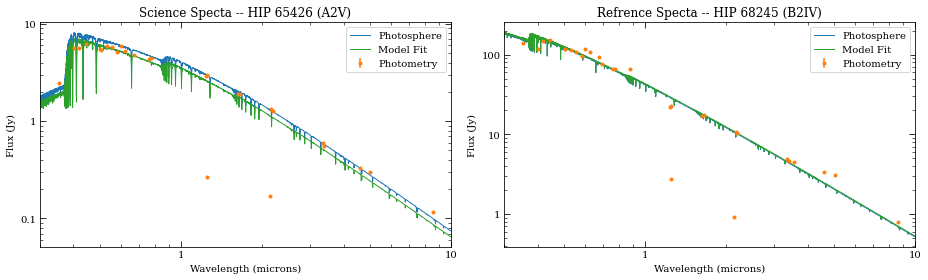

In [8]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(13,4))
src.plot_SED(xr=[0.3,10], ax=axes[0])
ref.plot_SED(xr=[0.3,10], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()

## Target Information

For each target specified in the APT file, we want to populate a dictionary with coordinate information and astrophysical properties. The dictionary keys should match the APT "Name in the Proposal" so that 

For each designated target, there are four types of objects that can be added: stellar source, point source companions, disk object, and/or a table of point sources specifying magnitudes in NIRCam filters.

In [9]:
# Initialize target dictionary
targ_dict = {}

# Bandpass corresponding to companion renormalization flux
bp_pl_norm = pynrc.read_filter('F250M')
# Assumed companion magnitudes in filter bandpass
# comp_mags = np.array([16.8])
comp_mags = np.array([10.8])

# Dictionary keywords should match APT target names
targ_dict['HIP-65426'] = {
    'type' : 'FixedTargetType',
    'TargetName' : 'HIP-65426', 'TargetArchiveName' : 'HD 116434',
    'EquatorialCoordinates' : "13 24 36.0980 -51 30 16.05",
    'RAProperMotion'  : -33.923*u.mas/u.yr, 
    'DecProperMotion' : -18.955*u.mas/u.yr, 
    'parallax' : 9.3031*u.mas, 'age_Myr' : 10,
    'params_star' : {'sp' : sp_sci},
    'params_companions' : {
        'b' : {'xy':(-4.417, -1.700), 'runits':'arcsec', 'mass':10,
               'renorm_args':(comp_mags[0], 'vegamag', bp_pl_norm)
              },
    },
    'params_disk_model' : None,
    'src_tbl' : None,
}

In [10]:
# Reference source
targ_dict['HIP-68245'] = {
    'type' : 'FixedTargetType',
    'TargetName' : 'HIP-68245', 'TargetArchiveName' : '* phi Cen',
    'EquatorialCoordinates' : "13 58 16.2351 -42 06 3.03",
    'RAProperMotion'  : -22.77*u.mas/u.yr, 
    'DecProperMotion' : -20.13*u.mas/u.yr, 
    'parallax' : 6.21*u.mas, 'age_Myr' : None,
    'params_star' : {'sp' : sp_ref},
    'params_companions' : None,
    'params_disk_model' : None,
    'src_tbl' : None,
}

In [11]:
# Populate coordinates and calculate distance from parallax info
for k in targ_dict.keys():
    d = targ_dict[k]
    dist = Distance(parallax=d['parallax']) if d['parallax'] is not None else None
    c = SkyCoord(d['EquatorialCoordinates'], frame='icrs', unit=(u.hourangle, u.deg),
                 pm_ra_cosdec=d['RAProperMotion'], pm_dec=d['DecProperMotion'],
                 distance=dist, obstime='J2000')
    d['sky_coords'] = c
    d['ra_J2000'], d['dec_J2000'] = (c.ra.deg, c.dec.deg)
    d['dist_pc'] = c.distance.value if dist is not None else None
    
    # Auto-generate source tables
#     src_tbl = make_gaia_source_table(c)
#     d['src_tbl'] = src_tbl if len(src_tbl)>0 else None

# Create Observation Parameters

These will used for input into the data ramp simulator and directly correspond to parameters for DMS FITS creation to ingest into the JWST pipeline

In [12]:
sim_config = {
    # APT input files
    'json_file'     : json_file,
    'sm_acct_file'  : sm_acct_file,
    'pointing_file' : pointing_file,
    'xml_file'      : xml_file,
    # Output directory
    'save_dir'      : save_dir,
    
    # Initialize random seeds if repeatability is required
    # Create separate random number generators for dithers and noise
    'rand_seed_init'  : 1234,
    
    # Date and time of observations
    'obs_date' : '2022-07-12', 
    'obs_time' : '12:00:00',
    # Position angle of observatory
    # User should check acceptable range in APT's Roll Analysis
    'pa_v3'    : None,
    
    # Source information
    'params_targets' : targ_dict,
    
    # PSF size information for WebbPSF_ext
    'params_webbpsf' : {'fov_pix': None, 'oversample': 2},
    # Position-dependent PSFs for convolution
    'params_psfconv' : {'npsf_per_full_fov': 9, 'osamp': 1, 'sptype': 'G0V'},
    # Wavefront error drift settings
    'params_wfedrift' : {'case': 'BOL', 'slew_init': 10, 'plot': False, 'figname': None},
    # For coronagraphic masks, sample large grid of points?
    'large_grid' : True,
    
    # Slew and dither pointing uncertainties
    'large_slew' : 100.0,   # Slew to target (mas)
    'ta_sam'     : 3.0,     # SAM movements from TA position (mas)
    'std_sam'    : 2.0,     # Standard dither values (mas)
    'sgd_sam'    : 1.0,     # Small grid dithers (mas)
    
    # Type of image files to save; can be supplied directly
    'save_slope' : False,  # Save ideal noiseless slope images to FITS
    'save_dms'   : False,  # Save DMS-like ramps to FITS
    'dry_run'    : False,  # Perform a dry-run, not generating any data, just printing visit info
    
    # Noise components to include in full DMS output
    'params_noise' : {
        'include_poisson'   : True,     # Photon Noise
        'include_dark'      : True,     # Dark current
        'include_bias'      : True,     # Bias image offset
        'include_ktc'       : True,     # kTC Noise
        'include_rn'        : True,     # Read Noise
        'include_cpink'     : True,     # Correlated 1/f noise between channel
        'include_upink'     : True,     # Channel-dependent 1/f noise
        'include_acn'       : True,     # Alternating column noise
        'apply_ipc'         : True,     # Interpixel capacitance
        'apply_ppc'         : True,     # Post-pixel coupling
        'amp_crosstalk'     : True,     # Amplifier crosstalk
        'include_refoffsets': True,     # Reference offsets
        'include_refinst'   : True,     # Reference pixel instabilities
        'include_colnoise'  : True,     # Transient detector column noise
        'add_crs'           : True,     # Include cosmic ray
        'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
        'cr_scale'          : 1,        # Cosmic ray probabilities scaling
        'apply_nonlinearity': True,     # Apply non-linearity
        'random_nonlin'     : True,     # Add randomness to non-linearity
        'apply_flats'       : True,     # pixel-to-pixel QE variations and field-dep illum
    },
}

## Perform simulations of observations

The next few cells demonstrate how to simulate observations for a single visit in the program (`001:001`). In order to generate a subset of observations, the `create_level1b_FITS` function has a few keyword settings, including `visit_id`, `apname`, `filter`, and `detname`. 

In addition, there are some diagnostic-level options to ensure simulations are being generated as expected before going through the long process of making everything.  makes sense during

 * `dry_run`: Won't generate any image data, but instead runs through each observation, printing detector info, SIAF aperture name, filter, visit IDs, exposure numbers, and dither information. If set to `None`, then grabs keyword from `sim_config` argument, otherwise defaults to `False` if not specified. If paired with `save_dms`, then will generate an empty set of DMS FITS files with headers populated, but data set to all zeros.
 * `save_slope`: Saves noiseless slope images to a separate DMS-like FITS file that is names `slope_{DMSfilename}`. If set to `None`, then grabs keyword from `sim_config`, otherwise defaults to False if not found. **No effect if `dry_run=True`.**
 * `save_dms`: Option to disable simulation of ramp data and creation of DMS FITS. If `dry_run=True`, then setting `save_dms=True` will save DMS FITS files populated with all zeros. If set to `None`, then grabs keyword from `sim_config`; if no keyword is found, then defaults to `True` if `dry_run=False`, otherwise False.


In [13]:
# Generate level1b FITS files from program
# To save only a subset of observations, use a variety of combination of
# visit_id, apname, filter, and detname keywords
res = create_level1b_FITS(sim_config, dry_run=False, save_slope=True, save_dms=False, 
                          visit_id='002:001', filter='F250M')

Obs Params:   0%|          | 0/279 [00:00<?, ?it/s]

Exposures:   0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
nrc, pa_v3, idl_off, wfe_drift_exp = res

In [55]:
nrc._fovmax_wfemask = 256

In [50]:
nrc.gen_wfemask_coeff(large_grid=True)

In [25]:
im_slope = nrc.gen_slope_image(PA=0, zfact=0, exclude_noise=True)

Companions:   0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
im_pl = nrc.gen_planets_image()

Companions:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
psf = nrc.calc_psf_from_coeff(coord_vals=(5,0), coord_frame='idl', return_hdul=False, return_oversample=False)

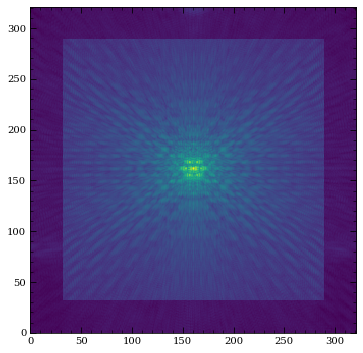

In [57]:
plt.imshow(psf**0.1)

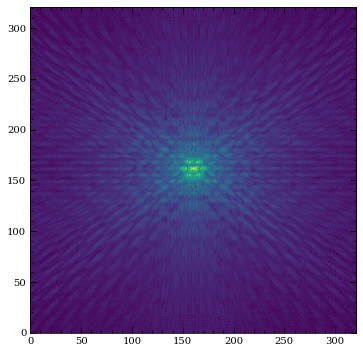

In [52]:
plt.imshow(psf**0.1)

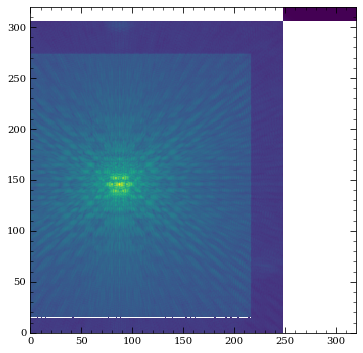

In [53]:
plt.imshow(im_pl**0.1)

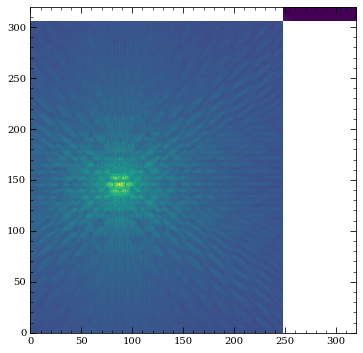

In [48]:
plt.imshow(im_pl**0.1)

In [58]:
from pynrc.nrc_utils import fshift

In [59]:
print(f'function: {fshift}')

function: <function fshift at 0x7fbf499bcc10>


In [38]:
# Generate level1b FITS files from program
# To save only a subset of observations, use a variety of combination of
# visit_id, apname, filter, and detname keywords
create_level1b_FITS(sim_config, dry_run=False, save_slope=True, save_dms=False, 
                    visit_id='002:001', filter='F250M')

Obs Params:   0%|          | 0/279 [00:00<?, ?it/s]

Exposures:   0%|          | 0/8 [00:00<?, ?it/s]

Companions:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_pid01386/slope_jw01386002001_03105_00001_nrca5_uncal.fits


In [ ]:
# Generate level1b FITS files from program
# To save only a subset of observations, use a variety of combination of
# visit_id, apname, filter, and detname keywords
create_level1b_FITS(sim_config, dry_run=True, save_slope=False, save_dms=False, 
                    visit_id='001:001')